In [ ]:
#default_exp utils.math.convertion

# Stereo to Point Cloud convertion

> What we want to achieve with this library is to be able to convert our given stereo image into a point cloud. Therefor we use the library Pseudo-Lidar from the user Mileyan (https://github.com/mileyan/pseudo_lidar). But first, we want to check the images which we will use for training. In our case, we will utilize the KITTI dataset, since it is widespread and easy to use.

### Display Images

In [ ]:
#hide
import pathlib
from IPython.display import Image

Firstly, we create the paths to two example images:

In [ ]:
kitti_path = pathlib.Path().absolute() / '..' / 'data' / 'kitti'
example_path_left = kitti_path /'training' /'image_2'/ '001512.png'
example_path_right = kitti_path / 'training' / 'image_3' / '001512.png'

kitti_path, example_path_left, example_path_right

(PosixPath('/home/qhs67/git/bachelorthesis_sven_thaele/code/nbs/../data/kitti'),
 PosixPath('/home/qhs67/git/bachelorthesis_sven_thaele/code/nbs/../data/kitti/training/image_2/001512.png'),
 PosixPath('/home/qhs67/git/bachelorthesis_sven_thaele/code/nbs/../data/kitti/training/image_3/001512.png'))

Then we can check out the images. The first one is from the left camera, the second comes from the camera on the right hand side.

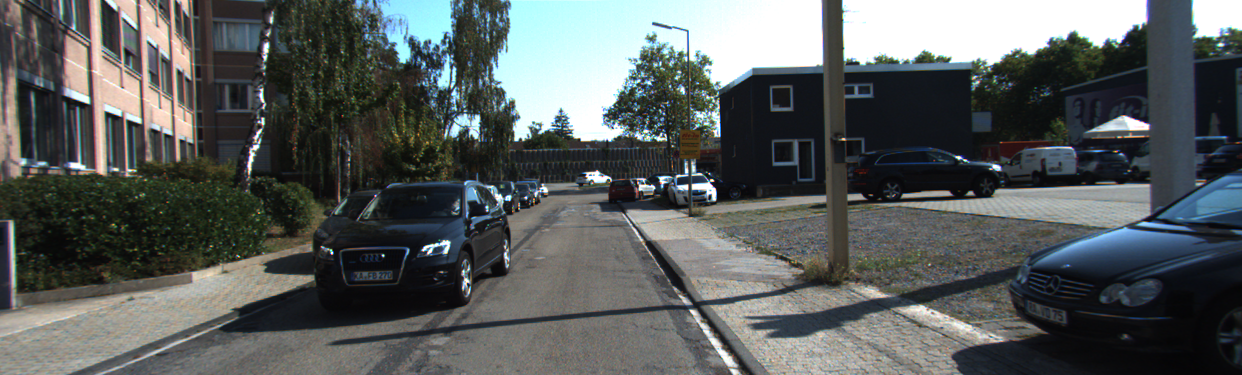

In [ ]:
Image(example_path_left)

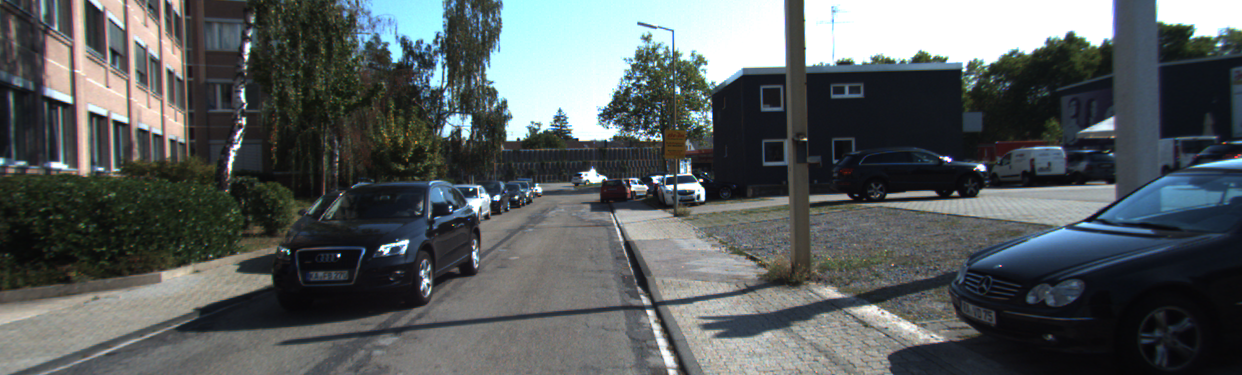

In [ ]:
Image(example_path_right)

## The actual convertion

What we want to do next is creating a class, which we will use for the convertion from a stereo image to a point cloud. As mentioned, the actual conversion can be done by Pseudo-Lidar, but we still have to embed the lib into our project.
Firstly we import the git project from the lib folder:

In [ ]:
#hide
import sys
sys.path.append("../lib/pslidar2/")

from src import main
from src.preprocess import generate_lidar_from_depth

For exporting we need to specify a different import path:

In [ ]:
#export
#skip

import sys
sys.path.append("../../lib/pslidar2/")

from src import main
from src.preprocess import generate_lidar_from_depth

Pseudo-Lidar works in a way, that as a first step,the stereo image has to be converted into disparity. Then those disparities can be converted to point clouds. So we will create the disparity method.

In [ ]:
#export
def generate_prediction(datapath, save_path, data_list, data_tag, split_train, split_val, pretrain, resume = None):
    # Set so the Pseudo-Lidar lib can use them
    args = main.Args
    args.datapath = datapath
    args.save_path = save_path
    args.data_list = data_list
    args.generate_depth_map = True
    args.data_tag = data_tag
    args.split_train = split_train
    args.split_val = split_val
    args.pretrain = pretrain
    args.resume = resume
    main.main(args)

This prediction given by the pseudolidar2 library then can be used to convert them into pseudo-lidar outputs in form of velodyne binary files. The requirements for this method are given by the lib, which include the directory of the previous generated predictions, as well as the calibration data, that can be downloaded on the Kitti dataset website.

In [ ]:
#export
def convert_to_pc(calib_dir, depth_dir, save_dir):
    args = generate_lidar_from_depth.Args()
    args.calib_dir = calib_dir
    args.depth_dir = depth_dir
    args.save_dir = save_dir
    generate_lidar_from_depth.main(args)

When working with the kitti dataset, we require to have a specific structure. This code will define the necessary paths to the data and will then interact with the pseudolidar2 library to convert our stereo image into point clouds.

In [ ]:
#export
def convert_stereo_to_pc(data_dir, pretrain):
    # make dirs
    split_train = data_dir + 'train.txt'
    split_val = data_dir + 'subval.txt'
    train_data_list = '/home/qhs67/git/bachelorthesis_sven_thaele/code/lib/pslidar2/split/trainval.txt'
    test_data_list = '/home/qhs67/git/bachelorthesis_sven_thaele/code/lib/pslidar2/split/test.txt'
    
    training_source_dir = data_dir + '/training'
    testing_source_dir = data_dir + '/testing'
    
    training_depth_dir = training_source_dir + '/depth_maps/depth_maps/trainval'
    testing_depth_dir = testing_source_dir + '/depth_maps/depth_maps/test'
    
    training_calib_dir = training_source_dir + '/calib'
    testing_calib_dir = testing_source_dir + '/calib'
    training_velodyne_dir = training_source_dir + '/pseudo_lidar'
    testing_velodyne_dir = testing_source_dir + '/pseudo_lidar'
    
    # training set
    #generate_prediction(training_source_dir, training_depth_dir, train_data_list, "trainval", split_train, split_val, pretrain)
    convert_to_pc(training_calib_dir, training_depth_dir, training_velodyne_dir)
    
    # testing set
    #generate_prediction(testing_source_dir, testing_depth_dir, test_data_list, 'test', split_train, split_val, pretrain)
    convert_to_pc(testing_calib_dir, testing_depth_dir, testing_velodyne_dir)

Calling our method to convert the downloaded kitti dataset into pseudo lidar data:

In [ ]:
#hide
#skip

# convert_stereo_to_pc('/home/qhs67/git/bachelorthesis_sven_thaele/code/data/kitti','/home/qhs67/git/bachelorthesis_sven_thaele/code/lib/pslidar2/sdn_kitti_object.pth')

### Displaying the results

In the end we also want to display the point clouds given by the algorithm

In [ ]:
#hide
import numpy as np
import struct
import open3d
from open3d import JVisualizer
import PIL.Image

Define the image number, which should be compared. The following section will show the Pseudo-Lidar and the normal Lidar point clouds, as well as the picture for reference.

In [ ]:
image_nbr = '004500'

In [ ]:
pseudo_location = '/home/qhs67/git/bachelorthesis_sven_thaele/code/data/kitti/training/pseudo_lidar/{}.bin'.format(image_nbr)
velodyne_location = '/home/qhs67/git/bachelorthesis_sven_thaele/code/data/kitti/training/velodyne/{}.bin'.format(image_nbr)
image_location = '/home/qhs67/git/bachelorthesis_sven_thaele/code/data/kitti/training/image_2/{}.png'.format(image_nbr)

We also need to create a function, that will convert the velodyne data into point clouds, which will be used by the open3d library. The method is defined bellow.

In [ ]:
#hide
# Load binary point cloud
#bin_pcd = np.fromfile(pseudo_location, dtype=np.float32)

# Reshape and drop reflection values
#points = bin_pcd.reshape((-1, 4))[:, 0:3]

# Convert to Open3D point cloud
#pcd_pseudo = open3d.open3d.geometry.PointCloud()
#pcd_pseudo.points = open3d.open3d.utility.Vector3dVector(points)

#points, points.shape

In [ ]:
#hide

def read_bin_velodyne(path):
    pc_list=[]
    with open(path,'rb') as f:
        content = f.read()
        pc_iter = struct.iter_unpack('ffff',content)
        for idx,point in enumerate(pc_iter):
            pc_list.append([point[0],point[1],point[2]])

    return np.asarray(pc_list,dtype=np.float32)

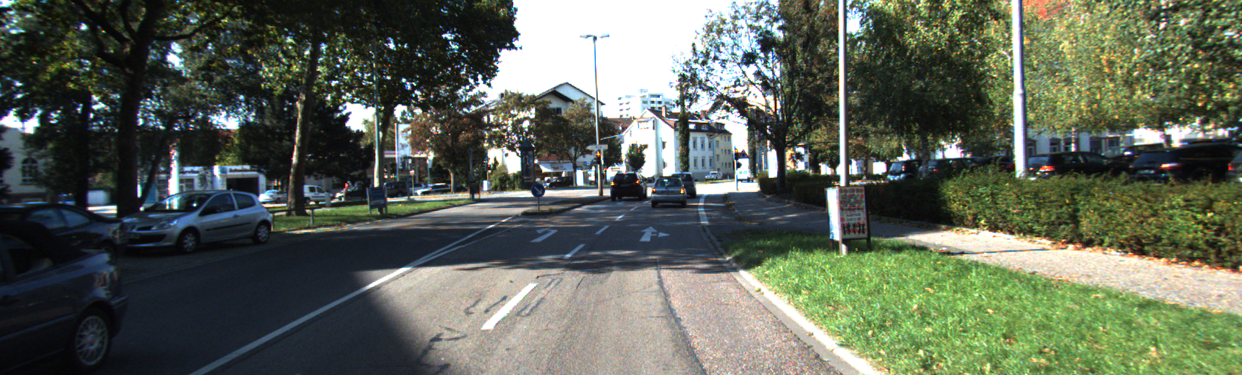

In [ ]:
Image(image_location)

### Pseudo Lidar data

In [ ]:
img = PIL.Image.open(image_location)
data_color = np.array(img, dtype=np.float64) / 255.0
data_color, data_color.shape

(array([[[0.79215686, 1.        , 1.        ],
         [0.76862745, 1.        , 1.        ],
         [0.9372549 , 1.        , 1.        ],
         ...,
         [0.44705882, 0.5254902 , 0.33333333],
         [0.47843137, 0.6       , 0.38823529],
         [0.56862745, 0.82352941, 0.36862745]],
 
        [[0.81960784, 0.76078431, 0.82352941],
         [0.81176471, 0.76862745, 0.98431373],
         [0.93333333, 0.9254902 , 1.        ],
         ...,
         [0.48627451, 0.60784314, 0.34509804],
         [0.52941176, 0.72156863, 0.37254902],
         [0.61568627, 0.76862745, 0.36470588]],
 
        [[0.44313725, 0.57647059, 0.78431373],
         [0.42352941, 0.65882353, 0.95294118],
         [0.75294118, 0.85098039, 1.        ],
         ...,
         [0.47058824, 0.66666667, 0.36078431],
         [0.47843137, 0.61176471, 0.36470588],
         [0.45882353, 0.4627451 , 0.35294118]],
 
        ...,
 
        [[0.03137255, 0.04313725, 0.04705882],
         [0.03529412, 0.03921569, 0.06274

In [ ]:
data_color = data_color.reshape(-1, 3)
data_color, data_color.shape

(array([[0.79215686, 1.        , 1.        ],
        [0.76862745, 1.        , 1.        ],
        [0.9372549 , 1.        , 1.        ],
        ...,
        [0.59215686, 0.61176471, 0.3254902 ],
        [0.55686275, 0.60784314, 0.35686275],
        [0.52941176, 0.59215686, 0.34509804]]),
 (465750, 3))

In [ ]:
data_pseudo = read_bin_velodyne(pseudo_location)
data_pseudo, data_pseudo.shape

(array([[ 4.618757  , -1.8849672 ,  0.9973214 ],
        [ 4.589034  , -1.8776594 ,  0.9899489 ],
        [ 4.560902  , -1.8709854 ,  0.98296845],
        ...,
        [ 5.097671  , -4.1209035 , -1.406153  ],
        [ 5.0850444 , -4.1166086 , -1.4027294 ],
        [ 5.071356  , -4.111356  , -1.3990117 ]], dtype=float32),
 (269539, 3))

In [ ]:
#hide
pcd_pseudo = open3d.open3d.geometry.PointCloud()
pcd_pseudo.points = open3d.open3d.utility.Vector3dVector(data_pseudo)
#pcd_pseudo.colors = open3d.open3d.utility.Vector3dVector(data_color)

In [ ]:
# visualize
visualizer_pseudo = JVisualizer()
visualizer_pseudo.add_geometry(pcd_pseudo)
visualizer_pseudo.show()

JVisualizer with 1 geometries

### Real Lidar data

As comparison we also downloaded the original point cloud data from the Kitti dataset and visualize them here:

In [ ]:
#hide
data_velodyne = read_bin_velodyne(velodyne_location)
pcd_velodyne = open3d.open3d.geometry.PointCloud()
pcd_velodyne.points = open3d.open3d.utility.Vector3dVector(data_velodyne)

In [ ]:
visualizer_pseudo = JVisualizer()
visualizer_pseudo.add_geometry(pcd_velodyne)
visualizer_pseudo.show()

JVisualizer with 1 geometries

### Other Methods for displaying data

Method from Pseudo-Lidar lib, that did not work:

In [ ]:
#hide
#from pyntcloud import PyntCloud
#import pandas as pd
#import os
#import numpy as np
#import PIL.Image as Image
#%matplotlib inline

In [ ]:
#hide
#def load_velo_scan(velo_filename):
#    scan = np.fromfile(velo_filename, dtype=np.float32)
#    scan = scan.reshape((-1, 4))
#    return scan

In [ ]:
#hide
#def paint_points(points, color=[192,0,0]):
#    # color = [r, g, b]
#    color = np.array([color])
#    new_pts = np.zeros([points.shape[0],6])
#    new_pts[:,:3] = points
#    new_pts[:, 3:] = new_pts[:, 3:] + color
#    return new_pts

In [ ]:
#hide
#path = '/home/qhs67/git/bachelorthesis_sven_thaele/code/data/kitti/training/pseudo_lidar/000041.bin'
#points = load_velo_scan(path)[:,:3]
#pd_points = pd.DataFrame(paint_points(points), columns=['x','y','z','red','green','blue'])

In [ ]:
#hide
#cloud = PyntCloud(pd_points)
#cloud.plot(initial_point_size=0.02)